# Data Preparation 1

This notebook consist in the first data preparation. Patients and Admissions files will be preprocessed. Then the creation of databases associated to intractable files directly with pandas DataFrames due to memory limitations (INPUTEVENTS_CV.csv, LABEVENTS.csv, NOTEEVENTS.csv, CHARTEVENTS.csv) is adressed. This approach is necessary because the use of SQL to query desired instances and put in the form of pandas DataFrame will help to automate the process of feature extraction.

Files from MIMIC III used in this notebook:
- PATIENTS.csv       (processed directly as a pandas DataFrame)
- ADMISSIONS.csv     (processed directly as a pandas DataFrame)


- INPUTEVENTS_CV.csv (processed through database INPUTEVENTS_CV.db creation)
- LABEVENTS.csv      (processed through database LABEVENTS.db creation)
- NOTEEVENTS.csv     (processed through database NOTEEVENTS.db creation)
- CHARTEVENTS.csv    (processed through database CHARTEVENTS.db creation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import pylab
import sqlite3
matplotlib.style.use('ggplot')

### PATIENTS.csv and ADMISSIONS.csv preprocessing

In [2]:
patients=pd.read_csv('data/PATIENTS.csv')
print(patients.shape)
print('unique SUBJECT_ID:', patients.SUBJECT_ID.nunique())
patients=patients.sort_values(by=['SUBJECT_ID'])
patients=patients.reset_index(drop=True)
patients.head()

(46520, 8)
unique SUBJECT_ID: 46520


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,1,2,M,2138-07-17 00:00:00,NaN,NaN,NaN,0
1,2,3,M,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1
2,3,4,F,2143-05-12 00:00:00,NaN,NaN,NaN,0
3,4,5,M,2103-02-02 00:00:00,NaN,NaN,NaN,0
4,5,6,F,2109-06-21 00:00:00,NaN,NaN,NaN,0


not interested in EXPIRE_FLAG attribute, we want to know if a subject death or not inside the hospital, not outside

this information is in HOSPITAL_EXPIRE_FLAG attribute in ADMISSIONS.csv file (nextly)

In [3]:
patients.isnull().sum()

ROW_ID             0
SUBJECT_ID         0
GENDER             0
DOB                0
DOD            30761
DOD_HOSP       36546
DOD_SSN        33142
EXPIRE_FLAG        0
dtype: int64

In [4]:
patients=patients[['SUBJECT_ID', 'GENDER', 'DOB']]
patients.head()

,SUBJECT_ID,GENDER,DOB
0,2,M,2138-07-17 00:00:00
1,3,M,2025-04-11 00:00:00
2,4,F,2143-05-12 00:00:00
3,5,M,2103-02-02 00:00:00
4,6,F,2109-06-21 00:00:00


In [5]:
admissions=pd.read_csv('data/ADMISSIONS.csv')
admissions=pd.merge(patients, admissions, on=['SUBJECT_ID'])
admissions=admissions.sort_values(by=['SUBJECT_ID'])
admissions=admissions.reset_index(drop=True)
print(admissions.shape)
print('unique SUBJECT_ID:', admissions.SUBJECT_ID.nunique())
print('unique HADM_ID   :', admissions.HADM_ID.nunique())
admissions.head()

(58976, 21)
unique SUBJECT_ID: 46520
unique HADM_ID   : 58976


,SUBJECT_ID,GENDER,DOB,ROW_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,...,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,2,M,2138-07-17 00:00:00,1,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,...,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
1,3,M,2025-04-11 00:00:00,2,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,...,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,4,F,2143-05-12 00:00:00,3,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,...,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,5,M,2103-02-02 00:00:00,4,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,...,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
4,6,F,2109-06-21 00:00:00,5,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,...,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1


In [6]:
admissions.isnull().sum()

SUBJECT_ID                  0
GENDER                      0
DOB                         0
ROW_ID                      0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64

In [7]:
admissions=admissions.drop(['ROW_ID', 'DEATHTIME', 'DISCHARGE_LOCATION', 'LANGUAGE', 'RELIGION', 
                            'MARITAL_STATUS', 'EDREGTIME', 'EDOUTTIME'], axis=1)
print(admissions.shape)
admissions.head()

(58976, 13)


,SUBJECT_ID,GENDER,DOB,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,2,M,2138-07-17 00:00:00,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,ASIAN,NEWBORN,0,1
1,3,M,2025-04-11 00:00:00,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,WHITE,HYPOTENSION,0,1
2,4,F,2143-05-12 00:00:00,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,Private,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,5,M,2103-02-02 00:00:00,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,ASIAN,NEWBORN,0,1
4,6,F,2109-06-21 00:00:00,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,WHITE,CHRONIC RENAL FAILURE/SDA,0,1


In [8]:
admissions['HAS_CHARTEVENTS_DATA'].value_counts()

1    57384
0     1592
Name: HAS_CHARTEVENTS_DATA, dtype: int64

We drop admissions without chartevents data

In [9]:
admissions=admissions[admissions['HAS_CHARTEVENTS_DATA']==1]
admissions=admissions.drop(['HAS_CHARTEVENTS_DATA'], axis=1)
print(admissions.shape)
admissions.head()

(57384, 12)


,SUBJECT_ID,GENDER,DOB,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG
0,2,M,2138-07-17 00:00:00,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,ASIAN,NEWBORN,0
1,3,M,2025-04-11 00:00:00,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,WHITE,HYPOTENSION,0
2,4,F,2143-05-12 00:00:00,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,Private,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0
3,5,M,2103-02-02 00:00:00,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,ASIAN,NEWBORN,0
4,6,F,2109-06-21 00:00:00,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,WHITE,CHRONIC RENAL FAILURE/SDA,0


In [10]:
admissions.columns

Index(['SUBJECT_ID', 'GENDER', 'DOB', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'ETHNICITY',
       'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG'],
      dtype='object')

Duration for each single admission

In [11]:
a=pd.to_datetime(admissions.DISCHTIME)-pd.to_datetime(admissions.ADMITTIME)
admissions['TIMEDELTA']=np.round(a.dt.total_seconds()/86400, 2)
admissions['TIMEDELTA_C']=np.where((admissions['TIMEDELTA']>0)&(admissions['TIMEDELTA']<2), '0-2',
                              np.where((admissions['TIMEDELTA']>=2)&(admissions['TIMEDELTA']<5), '2-5',
                                  np.where((admissions['TIMEDELTA']>=5)&(admissions['TIMEDELTA']<10), '5-10','>10')))
admissions=admissions[['SUBJECT_ID', 'HADM_ID', 'GENDER', 'DOB', 'ADMITTIME', 'DISCHTIME', 'TIMEDELTA', 'TIMEDELTA_C', 
               'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 
               'ETHNICITY', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG']]
print(admissions.shape)
admissions.head()

(57384, 14)


,SUBJECT_ID,HADM_ID,GENDER,DOB,ADMITTIME,DISCHTIME,TIMEDELTA,TIMEDELTA_C,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG
0,2,163353,M,2138-07-17 00:00:00,2138-07-17 19:04:00,2138-07-21 15:48:00,3.86,2-5,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,ASIAN,NEWBORN,0
1,3,145834,M,2025-04-11 00:00:00,2101-10-20 19:08:00,2101-10-31 13:58:00,10.78,>10,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,WHITE,HYPOTENSION,0
2,4,185777,F,2143-05-12 00:00:00,2191-03-16 00:28:00,2191-03-23 18:41:00,7.76,5-10,EMERGENCY,EMERGENCY ROOM ADMIT,Private,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0
3,5,178980,M,2103-02-02 00:00:00,2103-02-02 04:31:00,2103-02-04 12:15:00,2.32,2-5,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,ASIAN,NEWBORN,0
4,6,107064,F,2109-06-21 00:00:00,2175-05-30 07:15:00,2175-06-15 16:00:00,16.36,>10,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,WHITE,CHRONIC RENAL FAILURE/SDA,0


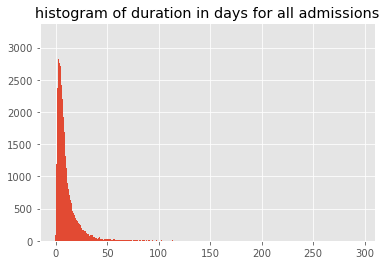

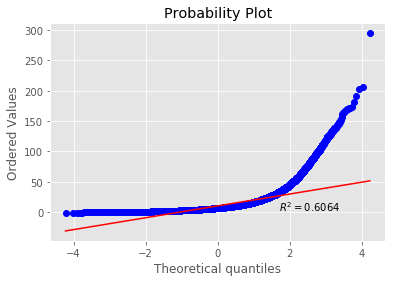

In [12]:
admissions['TIMEDELTA'].hist(bins=600)
plt.title('histogram of duration in days for all admissions')
plt.show()
stats.probplot(admissions['TIMEDELTA'], dist="norm", plot=pylab, rvalue=True)
pylab.show()

Preserve coherence TIMEDELTA>0 and moderate TIMEDELTA (outlier removal)

In [13]:
admissions=admissions[np.abs(admissions['TIMEDELTA']-admissions['TIMEDELTA'].mean()) 
                      <= 1*admissions['TIMEDELTA'].std()]
admissions=admissions[admissions['TIMEDELTA']>0]
print(admissions.shape)
admissions.head()

(52071, 14)


,SUBJECT_ID,HADM_ID,GENDER,DOB,ADMITTIME,DISCHTIME,TIMEDELTA,TIMEDELTA_C,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG
0,2,163353,M,2138-07-17 00:00:00,2138-07-17 19:04:00,2138-07-21 15:48:00,3.86,2-5,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,ASIAN,NEWBORN,0
1,3,145834,M,2025-04-11 00:00:00,2101-10-20 19:08:00,2101-10-31 13:58:00,10.78,>10,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,WHITE,HYPOTENSION,0
2,4,185777,F,2143-05-12 00:00:00,2191-03-16 00:28:00,2191-03-23 18:41:00,7.76,5-10,EMERGENCY,EMERGENCY ROOM ADMIT,Private,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0
3,5,178980,M,2103-02-02 00:00:00,2103-02-02 04:31:00,2103-02-04 12:15:00,2.32,2-5,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,ASIAN,NEWBORN,0
4,6,107064,F,2109-06-21 00:00:00,2175-05-30 07:15:00,2175-06-15 16:00:00,16.36,>10,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,WHITE,CHRONIC RENAL FAILURE/SDA,0


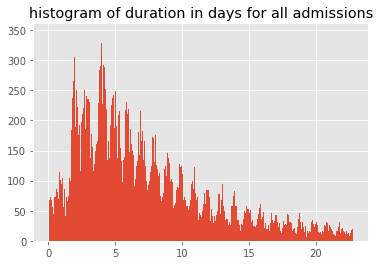

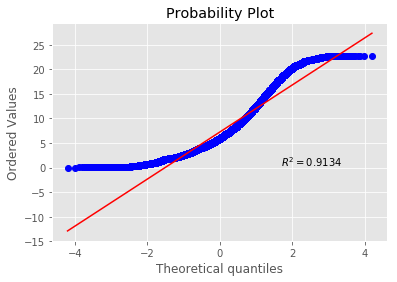

In [14]:
admissions['TIMEDELTA'].hist(bins=600)
plt.title('histogram of duration in days for all admissions')
plt.show()
stats.probplot(admissions['TIMEDELTA'], dist="norm", plot=pylab, rvalue=True)
pylab.show()

we compute the age at the time the patient is admitted from date of birth DOB, then we drop DOB

In [15]:
age=pd.to_datetime(admissions.ADMITTIME)-pd.to_datetime(admissions.DOB)
admissions['AGE_AD']=np.round(age.dt.total_seconds()/31557600, 2)
admissions=admissions.drop(['DOB'], axis=1)
print(admissions.shape)
admissions.head()

(52071, 14)


,SUBJECT_ID,HADM_ID,GENDER,ADMITTIME,DISCHTIME,TIMEDELTA,TIMEDELTA_C,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,AGE_AD
0,2,163353,M,2138-07-17 19:04:00,2138-07-21 15:48:00,3.86,2-5,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,ASIAN,NEWBORN,0,0.00
1,3,145834,M,2101-10-20 19:08:00,2101-10-31 13:58:00,10.78,>10,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,WHITE,HYPOTENSION,0,76.53
2,4,185777,F,2191-03-16 00:28:00,2191-03-23 18:41:00,7.76,5-10,EMERGENCY,EMERGENCY ROOM ADMIT,Private,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,47.84
3,5,178980,M,2103-02-02 04:31:00,2103-02-04 12:15:00,2.32,2-5,NEWBORN,PHYS REFERRAL/NORMAL DELI,Private,ASIAN,NEWBORN,0,0.00
4,6,107064,F,2175-05-30 07:15:00,2175-06-15 16:00:00,16.36,>10,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,WHITE,CHRONIC RENAL FAILURE/SDA,0,65.94


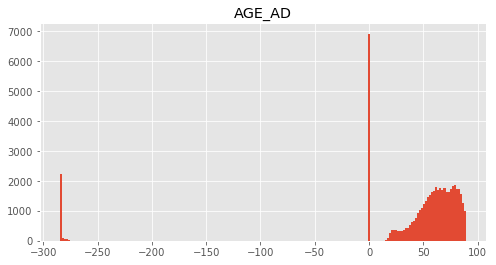

In [16]:
admissions.hist(column='AGE_AD', figsize=(8,4), bins=200)
plt.show()

We have newborn subject, they are not of our interest

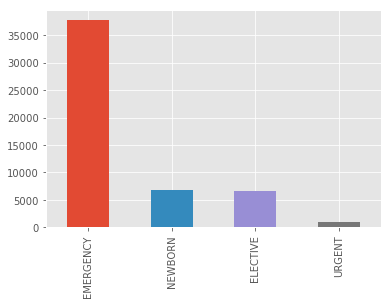

In [17]:
admissions['ADMISSION_TYPE'].value_counts().plot(kind='bar')
plt.show()

number admissions of patients older than 89 are negatively coded to preserve privacity (see MIMIC webpage)

In [18]:
older89=len(admissions[(admissions['AGE_AD']<0)])
older89

2475

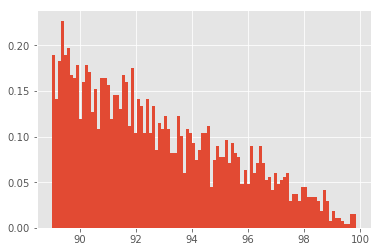

In [19]:
h=plt.hist(np.random.triangular(89.01, 89.01, 100, older89), bins=100, normed=True)
plt.show()

fill random triangular age to patients older than 89

not interested on patients younger than 16 

In [20]:
admissions['AGE_AD']=admissions['AGE_AD'].apply(lambda x: np.random.triangular(89.01, 89.01, 100) if x < 0 else x)
admissions=admissions[admissions['AGE_AD']>16]

(45159, 14)


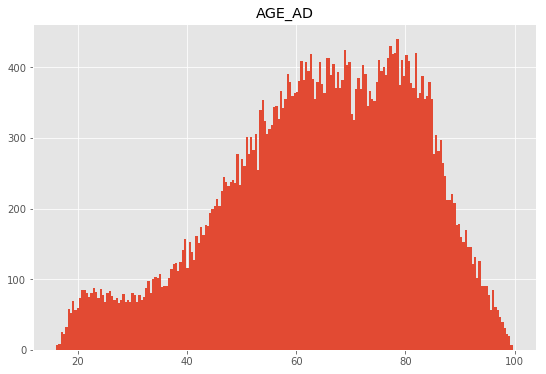

In [21]:
admissions.hist(column='AGE_AD', figsize=(9,6), bins=200)
print(admissions.shape)
plt.show()

In [22]:
admissions['AGE_C']=np.where((admissions['AGE_AD']>16)&(admissions['AGE_AD']<=40), '16-40',
                        np.where((admissions['AGE_AD']>40)&(admissions['AGE_AD']<=60), '40-60',
                            np.where((admissions['AGE_AD']>60)&(admissions['AGE_AD']<=80), '60-80', 'aged (>80)')))

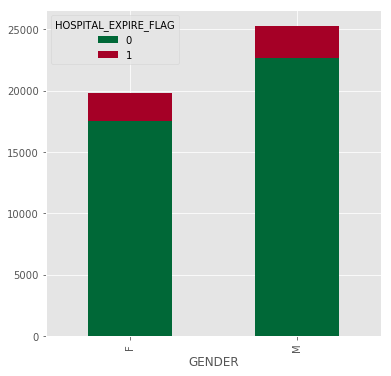

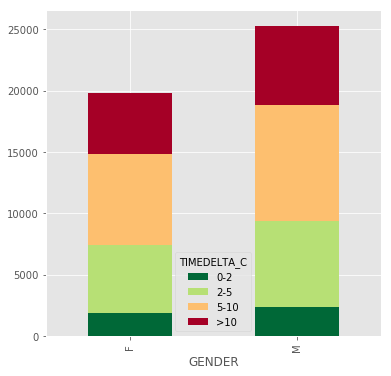

In [23]:
carat_table = pd.crosstab(index=admissions["GENDER"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["GENDER"], 
                          columns=admissions["TIMEDELTA_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

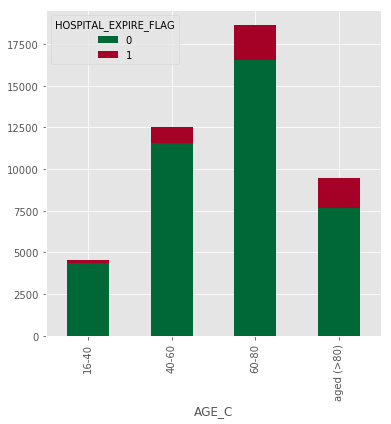

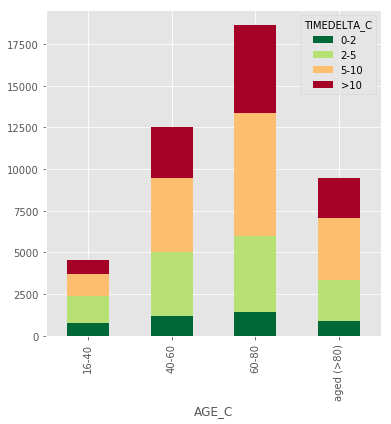

In [24]:
carat_table = pd.crosstab(index=admissions["AGE_C"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["AGE_C"], 
                          columns=admissions["TIMEDELTA_C"])
#carat_table=carat_table.reindex(["young", "20-60", "60-89", 'aged (>89)'])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

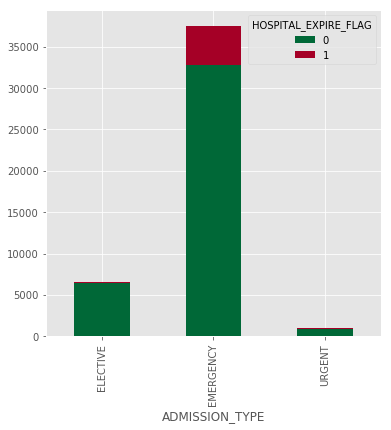

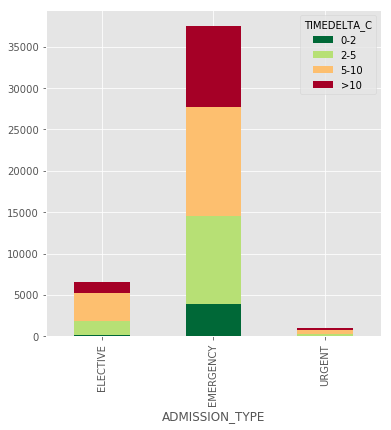

In [25]:
carat_table = pd.crosstab(index=admissions["ADMISSION_TYPE"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["ADMISSION_TYPE"], 
                          columns=admissions["TIMEDELTA_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

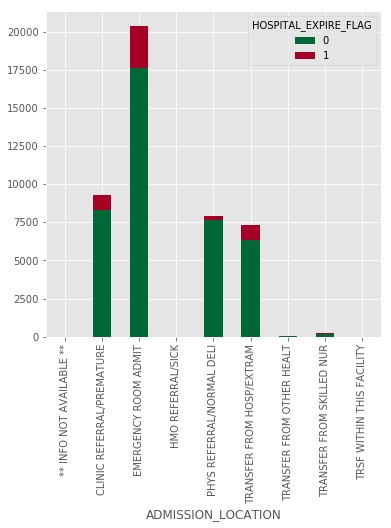

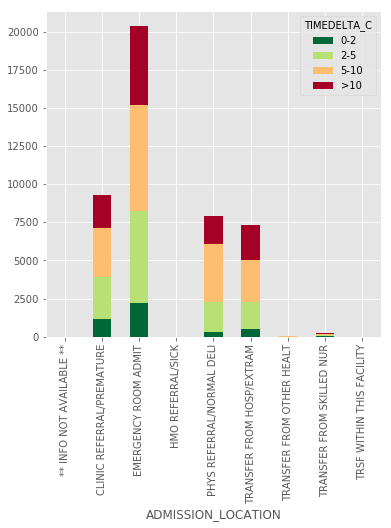

In [26]:
carat_table = pd.crosstab(index=admissions["ADMISSION_LOCATION"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["ADMISSION_LOCATION"], 
                          columns=admissions["TIMEDELTA_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

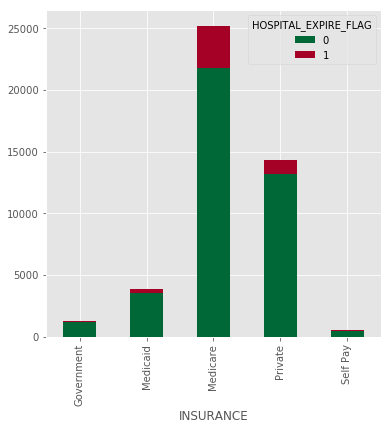

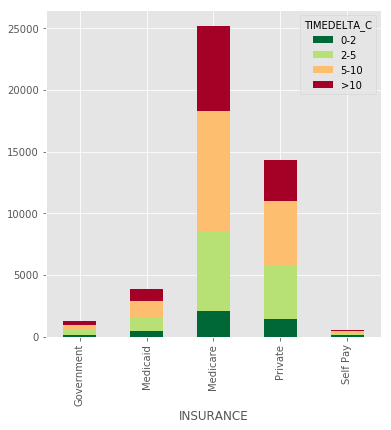

In [27]:
carat_table = pd.crosstab(index=admissions["INSURANCE"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["INSURANCE"], 
                          columns=admissions["TIMEDELTA_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

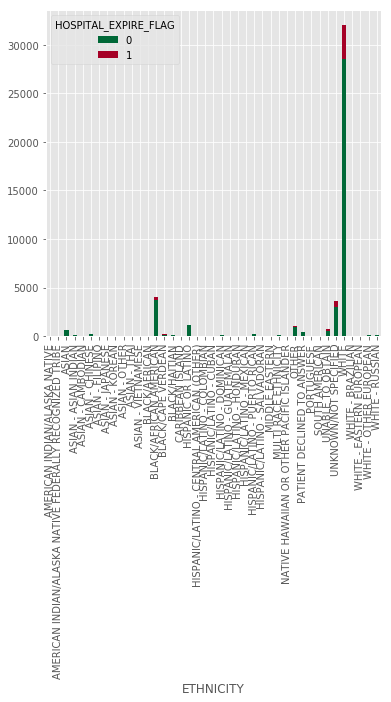

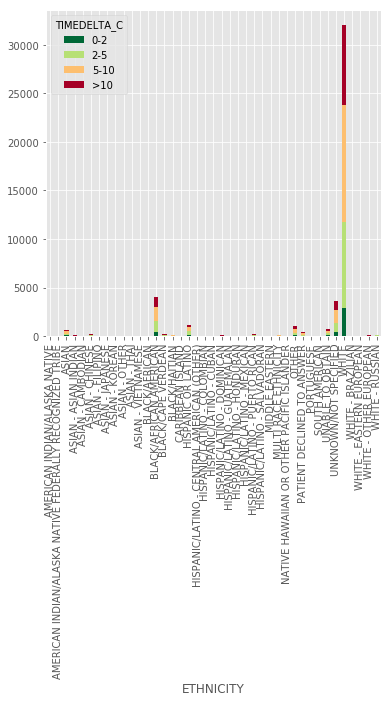

In [28]:
carat_table = pd.crosstab(index=admissions["ETHNICITY"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["ETHNICITY"], 
                          columns=admissions["TIMEDELTA_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

In [29]:
admissions=admissions.drop(['AGE_C'], axis=1)
admissions=admissions[['SUBJECT_ID', 'HADM_ID', 'GENDER', 'AGE_AD', 'ADMITTIME', 'DISCHTIME', 'TIMEDELTA', 
                       'TIMEDELTA_C', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 
                       'ETHNICITY', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG']]
admissions=admissions.reset_index(drop=True)
print(admissions.shape)
admissions.head()

(45159, 14)


,SUBJECT_ID,HADM_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,TIMEDELTA,TIMEDELTA_C,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG
0,3,145834,M,76.53,2101-10-20 19:08:00,2101-10-31 13:58:00,10.78,>10,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,WHITE,HYPOTENSION,0
1,4,185777,F,47.84,2191-03-16 00:28:00,2191-03-23 18:41:00,7.76,5-10,EMERGENCY,EMERGENCY ROOM ADMIT,Private,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0
2,6,107064,F,65.94,2175-05-30 07:15:00,2175-06-15 16:00:00,16.36,>10,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,WHITE,CHRONIC RENAL FAILURE/SDA,0
3,9,150750,M,41.79,2149-11-09 13:06:00,2149-11-14 10:15:00,4.88,2-5,EMERGENCY,EMERGENCY ROOM ADMIT,Medicaid,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,1
4,12,112213,M,72.37,2104-08-07 10:15:00,2104-08-20 02:57:00,12.70,>10,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,WHITE,PANCREATIC CANCER/SDA,1


In [30]:
admissions.HOSPITAL_EXPIRE_FLAG.value_counts()

0    40134
1     5025
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [31]:
admissions.isnull().sum()

SUBJECT_ID              0
HADM_ID                 0
GENDER                  0
AGE_AD                  0
ADMITTIME               0
DISCHTIME               0
TIMEDELTA               0
TIMEDELTA_C             0
ADMISSION_TYPE          0
ADMISSION_LOCATION      0
INSURANCE               0
ETHNICITY               0
DIAGNOSIS               4
HOSPITAL_EXPIRE_FLAG    0
dtype: int64

In [32]:
print('unique subject id:', admissions.SUBJECT_ID.nunique())
print('unique hadmiss id:', admissions.HADM_ID.nunique())

unique subject id: 36055
unique hadmiss id: 45159


From the original 58976 unique admissions associated to a total of 46520 different patients, we have now 45159 admissions of 36055 different patients

We have patients with a single hospital admission and patients with several hospital admissions

In [33]:
admissions[admissions['SUBJECT_ID']==3]

,SUBJECT_ID,HADM_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,TIMEDELTA,TIMEDELTA_C,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG
0,3,145834,M,76.53,2101-10-20 19:08:00,2101-10-31 13:58:00,10.78,>10,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,WHITE,HYPOTENSION,0


In [34]:
admissions[admissions['SUBJECT_ID']==17]

,SUBJECT_ID,HADM_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,TIMEDELTA,TIMEDELTA_C,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG
6,17,161087,F,47.82,2135-05-09 14:11:00,2135-05-13 14:40:00,4.02,2-5,EMERGENCY,EMERGENCY ROOM ADMIT,Private,WHITE,PERICARDIAL EFFUSION,0
7,17,194023,F,47.45,2134-12-27 07:15:00,2134-12-31 16:05:00,4.37,2-5,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Private,WHITE,PATIENT FORAMEN OVALE\ PATENT FORAMEN OVALE MI...,0


In [35]:
admissions.to_csv('MAIN_DF.csv')

# DATABASE CREATIONS

### INPUTEVENTS_CV.db Database creation from INPUTEVENTS_CV.csv

In [29]:
connex = sqlite3.connect("data/INPUTEVENTS_CV.db")

In [31]:
for chunk in pd.read_csv('data/INPUTEVENTS_CV.csv', chunksize=1000000):
    chunk.to_sql(name="INPUTEVENTS_CV_DB", con=connex, if_exists="append", index=False)

/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,9,17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, co

### LABEVENTS.db Database creation from LABEVENTS.csv

In [32]:
connex = sqlite3.connect("data/LABEVENTS.db")

In [34]:
for chunk in pd.read_csv('data/LABEVENTS.csv', chunksize=1000000):
    chunk.to_sql(name="LABEVENTS_DB", con=connex, if_exists="append", index=False)

### NOTEEVENTS.db Database creation from NOTEEVENTS.csv

In [41]:
connex = sqlite3.connect("data/NOTEEVENTS.db")

In [36]:
for chunk in pd.read_csv('data/NOTEEVENTS.csv', chunksize=1000000):
    chunk.to_sql(name="NOTEEVENTS_DB", con=connex, if_exists="append", index=False)

/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### CHARTEVENTS.db Database creation from CHARTEVENTS.csv

In [111]:
connex = sqlite3.connect("data/CHARTEVENTS.db")

In [23]:
for chunk in pd.read_csv('data/CHARTEVENTS.csv', chunksize=1000000):
    chunk.to_sql(name="CHARTEVENTS_DB", con=connex, if_exists="append", index=False)

### Example of extraction of SUBJECT_ID nº 34 from CHARTEVENTS_DB
From CHARTEVENTS_DB to a pandas DataFrame

In [307]:
connex = sqlite3.connect("data/CHARTEVENTS.db")

In [308]:
cur = connex.cursor()

In [309]:
ids = [34]
ids = [str(id) for id in ids] 
str_matching = "(" + ",".join(ids) + ")"  # Construct the string of SQL
print(str_matching)

(34)


In [310]:
#sql = "SELECT DISTINCT SUBJECT_ID FROM CHARTEVENTS_DB;"
sql = "SELECT * FROM CHARTEVENTS_DB WHERE SUBJECT_ID IN " + str_matching + ";"
print('String of SQL   :', sql)
print('Object Execution:', cur.execute(sql))

String of SQL   : SELECT * FROM CHARTEVENTS_DB WHERE SUBJECT_ID IN (34);
Object Execution: <sqlite3.Cursor object at 0x7f376fc046c0>


In [311]:
df = pd.read_sql_query(sql, connex)
print(type(df))
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
(2498, 15)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,326,34,144319,290505.0,220180,2191-02-23 05:30:00,2191-02-23 07:45:00,17741.0,66,66.0,mmHg,0.0,0.0,None,None
1,327,34,144319,290505.0,220181,2191-02-23 05:30:00,2191-02-23 07:45:00,17741.0,78,78.0,mmHg,0.0,0.0,None,None
2,328,34,144319,290505.0,223875,2191-02-23 07:00:00,2191-02-23 07:36:00,16924.0,10,10.0,insp/min,0.0,0.0,None,None
3,329,34,144319,290505.0,224690,2191-02-23 07:00:00,2191-02-23 07:35:00,16924.0,22,22.0,insp/min,0.0,0.0,None,None
4,330,34,144319,290505.0,224696,2191-02-23 07:00:00,2191-02-23 07:35:00,16924.0,16,16.0,cmH2O,0.0,0.0,None,None


The use of SQL through sqlite3 library will help to automate the feature extraction process